#Predicting News Category With BERT In Tensorflow

---

Bidirectional Encoder Representations from Transformers or BERT for short is a very popular NLP model from Google known for producing state-of-the-art results in a wide variety of NLP tasks.

The importance of Natural Language Processing(NLP) is profound in the Artificial Intelligence domain. The most abundant data in the world today is in the form of texts and having a powerful text processing system is critical and is more than  just a necessity.

In this article we look at implementing a multi-class classification using the state-of-the-art model, BERT.

---

Pre-Requisites:

* An Understanding of BERT
---

##About Dataset

For this article, we will use MachineHack’s [Predict The News Category Hackathon](https://www.machinehack.com/course/predict-the-news-category-hackathon/) data. The data  consists of a collection of news articles which are categorized into four sections. The features of the datasets are as follows:

Size of training set: 7,628 records
Size of test set: 2,748 records

FEATURES:

STORY:  A part of the main content of the article to be published as a piece of news.
SECTION: The genre/category the STORY falls in.

There are four distinct sections where each story may fall in to. The Sections are labelled as follows :
Politics: 0
Technology: 1
Entertainment: 2
Business: 3


Published @ [www.analyticsindiamaga.com](https://analyticsindiamag.com/step-by-step-guide-to-implementing-multi-class-classification-with-bert-tensorflow/)

##Mounting Google Drive

---
Here I have uploaded the dataset in to my Google Drive folder. To access the datasets we must first mount the drive in google colab. Type in and enter the following code to authenticate and mount your Google drive on to colab.



In [0]:
from google.colab import drive
drive.mount("/GD")

Drive already mounted at /GD; to attempt to forcibly remount, call drive.mount("/GD", force_remount=True).


## Importing Necessary Libraries

In [0]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.0
tensorflow_hub version :  0.7.0


In [0]:
#Installing BERT module
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.3MB/s 


In [0]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

##Setting The Output Directory
---
While fine-tuning the model, we will save the training checkpoints and the model in an output directory so that we can use the trained model for our predictions later.

The following code block sets an output directory :



In [0]:
# Set the output directory for saving model file
OUTPUT_DIR = '/GD/My Drive/Colab Notebooks/BERT/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /GD/My Drive/Colab Notebooks/BERT/bert_news_category *****


##Loading The Data
---
We will now load the data from a Google Drive directory and will also split the training set in to training and validation sets.


In [0]:
train = pd.read_excel("/GD/My Drive/Colab Notebooks/News_category/Datasets/Data_Train.xlsx")
test = pd.read_excel("/GD/My Drive/Colab Notebooks/News_category/Datasets/Data_Test.xlsx")

from sklearn.model_selection import train_test_split

train, val =  train_test_split(train, test_size = 0.2, random_state = 100)

In [0]:
#Training set sample
train.head(5)

,STORY,SECTION
4359,Oil prices extended its rally to a five-month ...,3
3520,Apple shares have risen more than 10% in March...,1
4530,The veteran actor plays a retired army officer...,2
6945,"BuzzFeed could use a boost. Two years ago, the...",1
2298,Bigg Boss Tamil 2 fame Mahat Raghavendra on We...,2


In [0]:
#Test set sample
test.head()

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...


In [0]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
print("Test Set Shape :", test.shape)

Training Set Shape : (6102, 2)
Validation Set Shape : (1526, 2)
Test Set Shape : (2748, 1)


In [0]:
#Features in the dataset
train.columns

Index(['STORY', 'SECTION'], dtype='object')

In [0]:
#unique classes
train['SECTION'].unique()

array([3, 1, 2, 0])

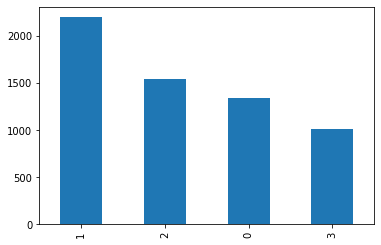

In [0]:
#Distribution of classes
train['SECTION'].value_counts().plot(kind = 'bar')

In [0]:
DATA_COLUMN = 'STORY'
LABEL_COLUMN = 'SECTION'
# The list containing all the classes (train['SECTION'].unique())
label_list = [0, 1, 2, 3]

## Data Preprocessing

BERT model accept only a specific type of input and the datasets are usually structuress to have have the following four features:

* guid : A unique id that represents an observation.
* text_a : The text we need to classify into given categories
* text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.
* label: It consists of the labels or classes or categories that a given text belongs to.
 
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.


In [0]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [0]:
train_InputExamples

4359    <bert.run_classifier.InputExample object at 0x...
3520    <bert.run_classifier.InputExample object at 0x...
4530    <bert.run_classifier.InputExample object at 0x...
6945    <bert.run_classifier.InputExample object at 0x...
2298    <bert.run_classifier.InputExample object at 0x...
                              ...                        
79      <bert.run_classifier.InputExample object at 0x...
3927    <bert.run_classifier.InputExample object at 0x...
5955    <bert.run_classifier.InputExample object at 0x...
6936    <bert.run_classifier.InputExample object at 0x...
5640    <bert.run_classifier.InputExample object at 0x...
Length: 6102, dtype: object

In [0]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  Oil prices extended its rally to a five-month high as conflict in Libya increased the risk of new supply outages


Indian rupee today weakened marginally against US dollar, tracking losses in other Asian currencies as traders awaited further details on a possible US-China trade deal. Higher crude oil prices also dampened sentiment. At 9.15 am, the rupee was trading at 69.46 a dollar, down 0.34% from its previous close of 69.23. The home currency opened at 69.34 a dollar.

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  3


We will now get down to business with the pretrained BERT.  In this example we will use the ```bert_uncased_L-12_H-768_A-12/1``` model. To check all available versions click [here](https://tfhub.dev/s?network-architecture=transformer&publisher=google).

We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.

---

The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.


In [0]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['oil', 'prices', 'extended', 'its', 'rally', 'to', 'a', 'five', '-', 'month', 'high', 'as', 'conflict', 'in', 'libya', 'increased', 'the', 'risk', 'of', 'new', 'supply', 'out', '##ages', 'indian', 'ru', '##pee', 'today', 'weakened', 'marginal', '##ly', 'against', 'us', 'dollar', ',', 'tracking', 'losses', 'in', 'other', 'asian', 'cu', '##rre', '##ncies', 'as', 'traders', 'awaited', 'further', 'details', 'on', 'a', 'possible', 'us', '-', 'china', 'trade', 'deal', '.', 'higher', 'crude', 'oil', 'prices', 'also', 'damp', '##ened', 'sentiment', '.', 'at', '9', '.', '15', 'am', ',', 'the', 'ru', '##pee', 'was', 'trading', 'at', '69', '.', '46', 'a', 'dollar', ',', 'down', '0', '.', '34', '%', 'from', 'its', 'previous', 'close', 'of', '69', '.', '23', '.', 'the', 'home', 'currency', 'opened', 'at', '69', '.', '34', 'a', 'dollar', '.']


We will now format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [0]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 6102


INFO:tensorflow:Writing example 0 of 6102


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] oil prices extended its rally to a five - month high as conflict in libya increased the risk of new supply out ##ages indian ru ##pee today weakened marginal ##ly against us dollar , tracking losses in other asian cu ##rre ##ncies as traders awaited further details on a possible us - china trade deal . higher crude oil prices also damp ##ened sentiment . at 9 . 15 am , the ru ##pee was trading at 69 . 46 a dollar , down 0 . 34 % from its previous close of 69 . 23 . the home currency opened at 69 . 34 a dollar . [SEP]


INFO:tensorflow:tokens: [CLS] oil prices extended its rally to a five - month high as conflict in libya increased the risk of new supply out ##ages indian ru ##pee today weakened marginal ##ly against us dollar , tracking losses in other asian cu ##rre ##ncies as traders awaited further details on a possible us - china trade deal . higher crude oil prices also damp ##ened sentiment . at 9 . 15 am , the ru ##pee was trading at 69 . 46 a dollar , down 0 . 34 % from its previous close of 69 . 23 . the home currency opened at 69 . 34 a dollar . [SEP]


INFO:tensorflow:input_ids: 101 3514 7597 3668 2049 8320 2000 1037 2274 1011 3204 2152 2004 4736 1999 12917 3445 1996 3891 1997 2047 4425 2041 13923 2796 21766 28084 2651 11855 14785 2135 2114 2149 7922 1010 9651 6409 1999 2060 4004 12731 14343 14767 2004 13066 19605 2582 4751 2006 1037 2825 2149 1011 2859 3119 3066 1012 3020 13587 3514 7597 2036 10620 6675 15792 1012 2012 1023 1012 2321 2572 1010 1996 21766 28084 2001 6202 2012 6353 1012 4805 1037 7922 1010 2091 1014 1012 4090 1003 2013 2049 3025 2485 1997 6353 1012 2603 1012 1996 2188 9598 2441 2012 6353 1012 4090 1037 7922 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3514 7597 3668 2049 8320 2000 1037 2274 1011 3204 2152 2004 4736 1999 12917 3445 1996 3891 1997 2047 4425 2041 13923 2796 21766 28084 2651 11855 14785 2135 2114 2149 7922 1010 9651 6409 1999 2060 4004 12731 14343 14767 2004 13066 19605 2582 4751 2006 1037 2825 2149 1011 2859 3119 3066 1012 3020 13587 3514 7597 2036 10620 6675 15792 1012 2012 1023 1012 2321 2572 1010 1996 21766 28084 2001 6202 2012 6353 1012 4805 1037 7922 1010 2091 1014 1012 4090 1003 2013 2049 3025 2485 1997 6353 1012 2603 1012 1996 2188 9598 2441 2012 6353 1012 4090 1037 7922 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] apple shares have risen more than 10 % in march to a four - month high ahead of monday ’ s event . here ’ s what to watch out for : the service will focus on original content , including tv shows and movies from producers such as damien cha ##zell ##e , m . night shy ##ama ##lan , and op ##rah . there are documentaries , such as ' elephant queen , ' and animation ##s , like “ wolf ##walker ##s " by oscar - nominated studio cartoon saloon , along with a re - imagining of the “ amazing stories " from steven spielberg , and a drama starring jennifer an ##isto ##n and reese with ##ers ##poo ##n . an [SEP]


INFO:tensorflow:tokens: [CLS] apple shares have risen more than 10 % in march to a four - month high ahead of monday ’ s event . here ’ s what to watch out for : the service will focus on original content , including tv shows and movies from producers such as damien cha ##zell ##e , m . night shy ##ama ##lan , and op ##rah . there are documentaries , such as ' elephant queen , ' and animation ##s , like “ wolf ##walker ##s " by oscar - nominated studio cartoon saloon , along with a re - imagining of the “ amazing stories " from steven spielberg , and a drama starring jennifer an ##isto ##n and reese with ##ers ##poo ##n . an [SEP]


INFO:tensorflow:input_ids: 101 6207 6661 2031 13763 2062 2084 2184 1003 1999 2233 2000 1037 2176 1011 3204 2152 3805 1997 6928 1521 1055 2724 1012 2182 1521 1055 2054 2000 3422 2041 2005 1024 1996 2326 2097 3579 2006 2434 4180 1010 2164 2694 3065 1998 5691 2013 6443 2107 2004 12587 15775 24085 2063 1010 1049 1012 2305 11004 8067 5802 1010 1998 6728 10404 1012 2045 2024 15693 1010 2107 2004 1005 10777 3035 1010 1005 1998 7284 2015 1010 2066 1523 4702 26965 2015 1000 2011 7436 1011 4222 2996 9476 17078 1010 2247 2007 1037 2128 1011 16603 1997 1996 1523 6429 3441 1000 2013 7112 28740 1010 1998 1037 3689 4626 7673 2019 20483 2078 1998 15883 2007 2545 24667 2078 1012 2019 102


INFO:tensorflow:input_ids: 101 6207 6661 2031 13763 2062 2084 2184 1003 1999 2233 2000 1037 2176 1011 3204 2152 3805 1997 6928 1521 1055 2724 1012 2182 1521 1055 2054 2000 3422 2041 2005 1024 1996 2326 2097 3579 2006 2434 4180 1010 2164 2694 3065 1998 5691 2013 6443 2107 2004 12587 15775 24085 2063 1010 1049 1012 2305 11004 8067 5802 1010 1998 6728 10404 1012 2045 2024 15693 1010 2107 2004 1005 10777 3035 1010 1005 1998 7284 2015 1010 2066 1523 4702 26965 2015 1000 2011 7436 1011 4222 2996 9476 17078 1010 2247 2007 1037 2128 1011 16603 1997 1996 1523 6429 3441 1000 2013 7112 28740 1010 1998 1037 3689 4626 7673 2019 20483 2078 1998 15883 2007 2545 24667 2078 1012 2019 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the veteran actor plays a retired army officer who enjoys a formidable reputation in the village , thanks to the seemingly never - ending stories of his battle exploits [SEP]


INFO:tensorflow:tokens: [CLS] the veteran actor plays a retired army officer who enjoys a formidable reputation in the village , thanks to the seemingly never - ending stories of his battle exploits [SEP]


INFO:tensorflow:input_ids: 101 1996 8003 3364 3248 1037 3394 2390 2961 2040 15646 1037 18085 5891 1999 1996 2352 1010 4283 2000 1996 9428 2196 1011 4566 3441 1997 2010 2645 20397 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 8003 3364 3248 1037 3394 2390 2961 2040 15646 1037 18085 5891 1999 1996 2352 1010 4283 2000 1996 9428 2196 1011 4566 3441 1997 2010 2645 20397 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] buzz ##fe ##ed could use a boost . two years ago , the company was valued at $ 1 . 7 billion and its prospects seemed bright . but the digital - media industry has gotten tough ##er since then . the company laid off 100 people last fall and shut down its podcast team in september . before buzz ##fe ##ed investors can find an exit through a sale or public offering , the company needs to prove it can develop a diverse mix of revenue from creating tv shows and films , commerce , and licensing or mer ##chan ##dis ##ing . in an interview , chief executive jonah pere ##tti declined to discuss his company ’ s revenue for 2018 , but said [SEP]


INFO:tensorflow:tokens: [CLS] buzz ##fe ##ed could use a boost . two years ago , the company was valued at $ 1 . 7 billion and its prospects seemed bright . but the digital - media industry has gotten tough ##er since then . the company laid off 100 people last fall and shut down its podcast team in september . before buzz ##fe ##ed investors can find an exit through a sale or public offering , the company needs to prove it can develop a diverse mix of revenue from creating tv shows and films , commerce , and licensing or mer ##chan ##dis ##ing . in an interview , chief executive jonah pere ##tti declined to discuss his company ’ s revenue for 2018 , but said [SEP]


INFO:tensorflow:input_ids: 101 12610 7959 2098 2071 2224 1037 12992 1012 2048 2086 3283 1010 1996 2194 2001 11126 2012 1002 1015 1012 1021 4551 1998 2049 16746 2790 4408 1012 2021 1996 3617 1011 2865 3068 2038 5407 7823 2121 2144 2059 1012 1996 2194 4201 2125 2531 2111 2197 2991 1998 3844 2091 2049 16110 2136 1999 2244 1012 2077 12610 7959 2098 9387 2064 2424 2019 6164 2083 1037 5096 2030 2270 5378 1010 1996 2194 3791 2000 6011 2009 2064 4503 1037 7578 4666 1997 6599 2013 4526 2694 3065 1998 3152 1010 6236 1010 1998 13202 2030 21442 14856 10521 2075 1012 1999 2019 4357 1010 2708 3237 15617 23976 6916 6430 2000 6848 2010 2194 1521 1055 6599 2005 2760 1010 2021 2056 102


INFO:tensorflow:input_ids: 101 12610 7959 2098 2071 2224 1037 12992 1012 2048 2086 3283 1010 1996 2194 2001 11126 2012 1002 1015 1012 1021 4551 1998 2049 16746 2790 4408 1012 2021 1996 3617 1011 2865 3068 2038 5407 7823 2121 2144 2059 1012 1996 2194 4201 2125 2531 2111 2197 2991 1998 3844 2091 2049 16110 2136 1999 2244 1012 2077 12610 7959 2098 9387 2064 2424 2019 6164 2083 1037 5096 2030 2270 5378 1010 1996 2194 3791 2000 6011 2009 2064 4503 1037 7578 4666 1997 6599 2013 4526 2694 3065 1998 3152 1010 6236 1010 1998 13202 2030 21442 14856 10521 2075 1012 1999 2019 4357 1010 2708 3237 15617 23976 6916 6430 2000 6848 2010 2194 1521 1055 6599 2005 2760 1010 2021 2056 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] big ##g boss tamil 2 fame maha ##t rag ##haven ##dra on wednesday took to twitter to announce his engagement with longtime girlfriend pr ##achi mis ##hra the couple ’ s relationship had been in the spotlight since maha ##t ’ s participation in the second season of big ##g boss tamil on the show , he court ##ed many controversies due to his ill - tempered nature , which even led to physical fights [SEP]


INFO:tensorflow:tokens: [CLS] big ##g boss tamil 2 fame maha ##t rag ##haven ##dra on wednesday took to twitter to announce his engagement with longtime girlfriend pr ##achi mis ##hra the couple ’ s relationship had been in the spotlight since maha ##t ’ s participation in the second season of big ##g boss tamil on the show , he court ##ed many controversies due to his ill - tempered nature , which even led to physical fights [SEP]


INFO:tensorflow:input_ids: 101 2502 2290 5795 6008 1016 4476 24404 2102 17768 14650 7265 2006 9317 2165 2000 10474 2000 14970 2010 8147 2007 11155 6513 10975 21046 28616 13492 1996 3232 1521 1055 3276 2018 2042 1999 1996 17763 2144 24404 2102 1521 1055 6577 1999 1996 2117 2161 1997 2502 2290 5795 6008 2006 1996 2265 1010 2002 2457 2098 2116 25962 2349 2000 2010 5665 1011 22148 3267 1010 2029 2130 2419 2000 3558 9590 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2502 2290 5795 6008 1016 4476 24404 2102 17768 14650 7265 2006 9317 2165 2000 10474 2000 14970 2010 8147 2007 11155 6513 10975 21046 28616 13492 1996 3232 1521 1055 3276 2018 2042 1999 1996 17763 2144 24404 2102 1521 1055 6577 1999 1996 2117 2161 1997 2502 2290 5795 6008 2006 1996 2265 1010 2002 2457 2098 2116 25962 2349 2000 2010 5665 1011 22148 3267 1010 2029 2130 2419 2000 3558 9590 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:Writing example 0 of 1526


INFO:tensorflow:Writing example 0 of 1526


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] traders said , reduced demand from local jewel ##lers as well as retail buyers led to the slide in gold prices . in the international market , spot gold was trading at usd 1 , 299 . 30 an ounce while silver was at usd 15 . 31 an ounce in new york . [SEP]


INFO:tensorflow:tokens: [CLS] traders said , reduced demand from local jewel ##lers as well as retail buyers led to the slide in gold prices . in the international market , spot gold was trading at usd 1 , 299 . 30 an ounce while silver was at usd 15 . 31 an ounce in new york . [SEP]


INFO:tensorflow:input_ids: 101 13066 2056 1010 4359 5157 2013 2334 13713 12910 2004 2092 2004 7027 17394 2419 2000 1996 7358 1999 2751 7597 1012 1999 1996 2248 3006 1010 3962 2751 2001 6202 2012 13751 1015 1010 25926 1012 2382 2019 19471 2096 3165 2001 2012 13751 2321 1012 2861 2019 19471 1999 2047 2259 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 13066 2056 1010 4359 5157 2013 2334 13713 12910 2004 2092 2004 7027 17394 2419 2000 1996 7358 1999 2751 7597 1012 1999 1996 2248 3006 1010 3962 2751 2001 6202 2012 13751 1015 1010 25926 1012 2382 2019 19471 2096 3165 2001 2012 13751 2321 1012 2861 2019 19471 1999 2047 2259 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] a recent amazon job posting , seeking a quality assurance manager for alexa data services in bucharest , describes the role humans play : “ every day she [ alexa ] listen ##s to thousands of people talking to her about different topics and different languages , and she needs our help to make sense of it all . " the want ad continues : “ this is big data handling like you ’ ve never seen it . we ’ re creating , labeling , cu ##rating and analyzing vast quantities of speech on a daily basis . " amazon ’ s review process for speech data begins when alexa pulls a random , small sampling of customer voice recordings and sends the audio files [SEP]


INFO:tensorflow:tokens: [CLS] a recent amazon job posting , seeking a quality assurance manager for alexa data services in bucharest , describes the role humans play : “ every day she [ alexa ] listen ##s to thousands of people talking to her about different topics and different languages , and she needs our help to make sense of it all . " the want ad continues : “ this is big data handling like you ’ ve never seen it . we ’ re creating , labeling , cu ##rating and analyzing vast quantities of speech on a daily basis . " amazon ’ s review process for speech data begins when alexa pulls a random , small sampling of customer voice recordings and sends the audio files [SEP]


INFO:tensorflow:input_ids: 101 1037 3522 9733 3105 14739 1010 6224 1037 3737 16375 3208 2005 24969 2951 2578 1999 14261 1010 5577 1996 2535 4286 2377 1024 1523 2296 2154 2016 1031 24969 1033 4952 2015 2000 5190 1997 2111 3331 2000 2014 2055 2367 7832 1998 2367 4155 1010 1998 2016 3791 2256 2393 2000 2191 3168 1997 2009 2035 1012 1000 1996 2215 4748 4247 1024 1523 2023 2003 2502 2951 8304 2066 2017 1521 2310 2196 2464 2009 1012 2057 1521 2128 4526 1010 28847 1010 12731 15172 1998 20253 6565 12450 1997 4613 2006 1037 3679 3978 1012 1000 9733 1521 1055 3319 2832 2005 4613 2951 4269 2043 24969 8005 1037 6721 1010 2235 16227 1997 8013 2376 5633 1998 10255 1996 5746 6764 102


INFO:tensorflow:input_ids: 101 1037 3522 9733 3105 14739 1010 6224 1037 3737 16375 3208 2005 24969 2951 2578 1999 14261 1010 5577 1996 2535 4286 2377 1024 1523 2296 2154 2016 1031 24969 1033 4952 2015 2000 5190 1997 2111 3331 2000 2014 2055 2367 7832 1998 2367 4155 1010 1998 2016 3791 2256 2393 2000 2191 3168 1997 2009 2035 1012 1000 1996 2215 4748 4247 1024 1523 2023 2003 2502 2951 8304 2066 2017 1521 2310 2196 2464 2009 1012 2057 1521 2128 4526 1010 28847 1010 12731 15172 1998 20253 6565 12450 1997 4613 2006 1037 3679 3978 1012 1000 9733 1521 1055 3319 2832 2005 4613 2951 4269 2043 24969 8005 1037 6721 1010 2235 16227 1997 8013 2376 5633 1998 10255 1996 5746 6764 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] new delhi : the bharatiya janata party manifesto monday promised to increase intake capacity of central engineering , management , science and law institutions by 50 % over the next five years if voted to power but remains silent on the impending new education policy . central institutions encompass indian institutes of technology ( ii ##ts ) , indian institute of management ( ii ##ms ) , all indian institutions of medical science ( ai ##im ##s ) , national law universities , indian institute of science technology and research ( ii ##ser ) among others . [SEP]


INFO:tensorflow:tokens: [CLS] new delhi : the bharatiya janata party manifesto monday promised to increase intake capacity of central engineering , management , science and law institutions by 50 % over the next five years if voted to power but remains silent on the impending new education policy . central institutions encompass indian institutes of technology ( ii ##ts ) , indian institute of management ( ii ##ms ) , all indian institutions of medical science ( ai ##im ##s ) , national law universities , indian institute of science technology and research ( ii ##ser ) among others . [SEP]


INFO:tensorflow:input_ids: 101 2047 6768 1024 1996 24243 20308 2283 17124 6928 5763 2000 3623 13822 3977 1997 2430 3330 1010 2968 1010 2671 1998 2375 4896 2011 2753 1003 2058 1996 2279 2274 2086 2065 5444 2000 2373 2021 3464 4333 2006 1996 17945 2047 2495 3343 1012 2430 4896 25281 2796 12769 1997 2974 1006 2462 3215 1007 1010 2796 2820 1997 2968 1006 2462 5244 1007 1010 2035 2796 4896 1997 2966 2671 1006 9932 5714 2015 1007 1010 2120 2375 5534 1010 2796 2820 1997 2671 2974 1998 2470 1006 2462 8043 1007 2426 2500 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2047 6768 1024 1996 24243 20308 2283 17124 6928 5763 2000 3623 13822 3977 1997 2430 3330 1010 2968 1010 2671 1998 2375 4896 2011 2753 1003 2058 1996 2279 2274 2086 2065 5444 2000 2373 2021 3464 4333 2006 1996 17945 2047 2495 3343 1012 2430 4896 25281 2796 12769 1997 2974 1006 2462 3215 1007 1010 2796 2820 1997 2968 1006 2462 5244 1007 1010 2035 2796 4896 1997 2966 2671 1006 9932 5714 2015 1007 1010 2120 2375 5534 1010 2796 2820 1997 2671 2974 1998 2470 1006 2462 8043 1007 2426 2500 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] facebook declined to comment , while what ##sa ##pp and ins ##tagram did not immediately respond to a request for comment . the panel has previously summoned social network twitter inc ' s chief executive jack dorsey to appear on monday to discuss the same topic . " these are issues for all internet services globally , " twitter said on friday , adding that colin crowe ##ll , its global vice president of public policy , is to meet the panel on monday . [SEP]


INFO:tensorflow:tokens: [CLS] facebook declined to comment , while what ##sa ##pp and ins ##tagram did not immediately respond to a request for comment . the panel has previously summoned social network twitter inc ' s chief executive jack dorsey to appear on monday to discuss the same topic . " these are issues for all internet services globally , " twitter said on friday , adding that colin crowe ##ll , its global vice president of public policy , is to meet the panel on monday . [SEP]


INFO:tensorflow:input_ids: 101 9130 6430 2000 7615 1010 2096 2054 3736 9397 1998 16021 23091 2106 2025 3202 6869 2000 1037 5227 2005 7615 1012 1996 5997 2038 3130 11908 2591 2897 10474 4297 1005 1055 2708 3237 2990 27332 2000 3711 2006 6928 2000 6848 1996 2168 8476 1012 1000 2122 2024 3314 2005 2035 4274 2578 16452 1010 1000 10474 2056 2006 5958 1010 5815 2008 6972 25657 3363 1010 2049 3795 3580 2343 1997 2270 3343 1010 2003 2000 3113 1996 5997 2006 6928 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9130 6430 2000 7615 1010 2096 2054 3736 9397 1998 16021 23091 2106 2025 3202 6869 2000 1037 5227 2005 7615 1012 1996 5997 2038 3130 11908 2591 2897 10474 4297 1005 1055 2708 3237 2990 27332 2000 3711 2006 6928 2000 6848 1996 2168 8476 1012 1000 2122 2024 3314 2005 2035 4274 2578 16452 1010 1000 10474 2056 2006 5958 1010 5815 2008 6972 25657 3363 1010 2049 3795 3580 2343 1997 2270 3343 1010 2003 2000 3113 1996 5997 2006 6928 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] “ in my home , i often communicate in both english and hindi . so i ’ m very excited about this feature that lets me use the assistant in a more natural way , " said gupta . google india ##and ##roid goa ##nd ##roid go pie ##sam ##sun ##g galaxy j ##2 core ##no ##kia ##lav ##ami ##cr ##oma ##x ##go ##og ##le assistant ##go ##og ##le assistant marathi ##go ##og ##le go ##ma ##ps go [SEP]


INFO:tensorflow:tokens: [CLS] “ in my home , i often communicate in both english and hindi . so i ’ m very excited about this feature that lets me use the assistant in a more natural way , " said gupta . google india ##and ##roid goa ##nd ##roid go pie ##sam ##sun ##g galaxy j ##2 core ##no ##kia ##lav ##ami ##cr ##oma ##x ##go ##og ##le assistant ##go ##og ##le assistant marathi ##go ##og ##le go ##ma ##ps go [SEP]


INFO:tensorflow:input_ids: 101 1523 1999 2026 2188 1010 1045 2411 10639 1999 2119 2394 1998 9269 1012 2061 1045 1521 1049 2200 7568 2055 2023 3444 2008 11082 2033 2224 1996 3353 1999 1037 2062 3019 2126 1010 1000 2056 20512 1012 8224 2634 5685 22943 15244 4859 22943 2175 11345 21559 19729 2290 9088 1046 2475 4563 3630 21128 14973 10631 26775 9626 2595 3995 8649 2571 3353 3995 8649 2571 3353 18388 3995 8649 2571 2175 2863 4523 2175 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1523 1999 2026 2188 1010 1045 2411 10639 1999 2119 2394 1998 9269 1012 2061 1045 1521 1049 2200 7568 2055 2023 3444 2008 11082 2033 2224 1996 3353 1999 1037 2062 3019 2126 1010 1000 2056 20512 1012 8224 2634 5685 22943 15244 4859 22943 2175 11345 21559 19729 2290 9088 1046 2475 4563 3630 21128 14973 10631 26775 9626 2595 3995 8649 2571 3353 3995 8649 2571 3353 18388 3995 8649 2571 2175 2863 4523 2175 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [0]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  Oil prices extended its rally to a five-month high as conflict in Libya increased the risk of new supply outages


Indian rupee today weakened marginally against US dollar, tracking losses in other Asian currencies as traders awaited further details on a possible US-China trade deal. Higher crude oil prices also dampened sentiment. At 9.15 am, the rupee was trading at 69.46 a dollar, down 0.34% from its previous close of 69.23. The home currency opened at 69.34 a dollar.
------------------------------
Tokens :  ['oil', 'prices', 'extended', 'its', 'rally', 'to', 'a', 'five', '-', 'month', 'high', 'as', 'conflict', 'in', 'libya', 'increased', 'the', 'risk', 'of', 'new', 'supply', 'out', '##ages', 'indian', 'ru', '##pee', 'today', 'weakened', 'marginal', '##ly', 'against', 'us', 'dollar', ',', 'tracking', 'losses', 'in', 'other', 'asian', 'cu', '##rre', '##ncies', 'as', 'traders', 'awaited', 'further', 'details', 'on', 'a', 'possible', 'us', '-', 'china', 'trade', 'deal', '.'

##Creating A Multi-Class Classifier Model


In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


In [0]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/BERT/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5448672b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/BERT/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5448672b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


we will now create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

##Training & Evaluating

In [0]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:loss = 1.671329, step = 0


INFO:tensorflow:loss = 1.671329, step = 0


INFO:tensorflow:global_step/sec: 0.579778


INFO:tensorflow:global_step/sec: 0.579778


INFO:tensorflow:loss = 0.02809212, step = 100 (172.482 sec)


INFO:tensorflow:loss = 0.02809212, step = 100 (172.482 sec)


INFO:tensorflow:global_step/sec: 0.640514


INFO:tensorflow:global_step/sec: 0.640514


INFO:tensorflow:loss = 0.0046886336, step = 200 (156.124 sec)


INFO:tensorflow:loss = 0.0046886336, step = 200 (156.124 sec)


INFO:tensorflow:Saving checkpoints for 300 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 0.614066


INFO:tensorflow:global_step/sec: 0.614066


INFO:tensorflow:loss = 0.0064441273, step = 300 (162.853 sec)


INFO:tensorflow:loss = 0.0064441273, step = 300 (162.853 sec)


INFO:tensorflow:global_step/sec: 0.640734


INFO:tensorflow:global_step/sec: 0.640734


INFO:tensorflow:loss = 0.0016644242, step = 400 (156.068 sec)


INFO:tensorflow:loss = 0.0016644242, step = 400 (156.068 sec)


INFO:tensorflow:global_step/sec: 0.639597


INFO:tensorflow:global_step/sec: 0.639597


INFO:tensorflow:loss = 0.0014373187, step = 500 (156.353 sec)


INFO:tensorflow:loss = 0.0014373187, step = 500 (156.353 sec)


INFO:tensorflow:Saving checkpoints for 572 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 572 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Loss for final step: 0.013614067.


INFO:tensorflow:Loss for final step: 0.013614067.


Training took time  0:16:15.354629


In [0]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-14T11:32:13Z


INFO:tensorflow:Starting evaluation at 2019-11-14T11:32:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-11-14-11:32:46


INFO:tensorflow:Finished evaluation at 2019-11-14-11:32:46


INFO:tensorflow:Saving dict for global step 572: eval_accuracy = 0.98689383, false_negatives = 8.0, false_positives = 7.0, global_step = 572, loss = 0.060107384, true_negatives = 338.0, true_positives = 1173.0


INFO:tensorflow:Saving dict for global step 572: eval_accuracy = 0.98689383, false_negatives = 8.0, false_positives = 7.0, global_step = 572, loss = 0.060107384, true_negatives = 338.0, true_positives = 1173.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 572: /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 572: /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


{'eval_accuracy': 0.98689383,
 'false_negatives': 8.0,
 'false_positives': 7.0,
 'global_step': 572,
 'loss': 0.060107384,
 'true_negatives': 338.0,
 'true_positives': 1173.0}

##Vola !! We got an evaluation accuracy of 98% on the validation set by just having trained the model for 3 epochs and a few hundred steps.

##Predicting For Test Set

In [0]:
"""Politics: 0
Technology: 1
Entertainment: 2
Business: 3"""

# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ["Politics", "Technology","Entertainment","Business"]

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
pred_sentences = list(test['STORY'])

In [0]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 2748


INFO:tensorflow:Writing example 0 of 2748


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 2019 will see ga ##dgets like gaming smartphone ##s and wear ##able medical devices lifting the user experience to a whole new level mint - india - wire consumer technology ##con ##sume ##r technology trends in new year ##tech ga ##dgets ##fold ##able phones ##gami ##ng smartphone ##sw ##ear ##able medical devices ##tech ##nology new delhi : ga ##dgets have become an integral part of our lives with most of us relying on some form of factor to communicate , com ##mute , work , be informed or entertained . year 2019 will see some ga ##dgets lifting the user experience to a whole new level . here ’ s what we can expect to see : smartphone ##s with fold ##able screens : fold ##able [SEP]


INFO:tensorflow:tokens: [CLS] 2019 will see ga ##dgets like gaming smartphone ##s and wear ##able medical devices lifting the user experience to a whole new level mint - india - wire consumer technology ##con ##sume ##r technology trends in new year ##tech ga ##dgets ##fold ##able phones ##gami ##ng smartphone ##sw ##ear ##able medical devices ##tech ##nology new delhi : ga ##dgets have become an integral part of our lives with most of us relying on some form of factor to communicate , com ##mute , work , be informed or entertained . year 2019 will see some ga ##dgets lifting the user experience to a whole new level . here ’ s what we can expect to see : smartphone ##s with fold ##able screens : fold ##able [SEP]


INFO:tensorflow:input_ids: 101 10476 2097 2156 11721 28682 2066 10355 26381 2015 1998 4929 3085 2966 5733 8783 1996 5310 3325 2000 1037 2878 2047 2504 12927 1011 2634 1011 7318 7325 2974 8663 23545 2099 2974 12878 1999 2047 2095 15007 11721 28682 10371 3085 11640 26517 3070 26381 26760 14644 3085 2966 5733 15007 21020 2047 6768 1024 11721 28682 2031 2468 2019 9897 2112 1997 2256 3268 2007 2087 1997 2149 18345 2006 2070 2433 1997 5387 2000 10639 1010 4012 26746 1010 2147 1010 2022 6727 2030 21474 1012 2095 10476 2097 2156 2070 11721 28682 8783 1996 5310 3325 2000 1037 2878 2047 2504 1012 2182 1521 1055 2054 2057 2064 5987 2000 2156 1024 26381 2015 2007 10671 3085 12117 1024 10671 3085 102


INFO:tensorflow:input_ids: 101 10476 2097 2156 11721 28682 2066 10355 26381 2015 1998 4929 3085 2966 5733 8783 1996 5310 3325 2000 1037 2878 2047 2504 12927 1011 2634 1011 7318 7325 2974 8663 23545 2099 2974 12878 1999 2047 2095 15007 11721 28682 10371 3085 11640 26517 3070 26381 26760 14644 3085 2966 5733 15007 21020 2047 6768 1024 11721 28682 2031 2468 2019 9897 2112 1997 2256 3268 2007 2087 1997 2149 18345 2006 2070 2433 1997 5387 2000 10639 1010 4012 26746 1010 2147 1010 2022 6727 2030 21474 1012 2095 10476 2097 2156 2070 11721 28682 8783 1996 5310 3325 2000 1037 2878 2047 2504 1012 2182 1521 1055 2054 2057 2064 5987 2000 2156 1024 26381 2015 2007 10671 3085 12117 1024 10671 3085 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] it has also unleashed a wave of changes in the mc ##u that will make sure its future is a lot different than its past kevin fei ##ge had signal ##led diversity and more representation in the post - phase 3 mc ##u and end ##game does a lot to showcase the initiative [SEP]


INFO:tensorflow:tokens: [CLS] it has also unleashed a wave of changes in the mc ##u that will make sure its future is a lot different than its past kevin fei ##ge had signal ##led diversity and more representation in the post - phase 3 mc ##u and end ##game does a lot to showcase the initiative [SEP]


INFO:tensorflow:input_ids: 101 2009 2038 2036 22416 1037 4400 1997 3431 1999 1996 11338 2226 2008 2097 2191 2469 2049 2925 2003 1037 2843 2367 2084 2049 2627 4901 24664 3351 2018 4742 3709 8906 1998 2062 6630 1999 1996 2695 1011 4403 1017 11338 2226 1998 2203 16650 2515 1037 2843 2000 13398 1996 6349 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2009 2038 2036 22416 1037 4400 1997 3431 1999 1996 11338 2226 2008 2097 2191 2469 2049 2925 2003 1037 2843 2367 2084 2049 2627 4901 24664 3351 2018 4742 3709 8906 1998 2062 6630 1999 1996 2695 1011 4403 1017 11338 2226 1998 2203 16650 2515 1037 2843 2000 13398 1996 6349 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] it can be confusing to pick the right smartphone for yourself , so we have segregated the top smartphone ##s under rs 20 , 000 according to their strengths . the best smartphone ##s under ₹ ##20 , 000 cat ##ego ##rise ##d according to performance , camera , design and battery life mint - india - wire phones under rs 2000 ##0 ##po ##co f1 ##real ##me u ##1 ##red ##mi note 6 pro ##real ##me 2 pro ##hon ##or play ##no ##kia 7 . 1 ##nova 3 ##ias ##us zen ##fo ##ne max pro m1 gone are the days when you had to shell out big buck for buying smartphone ##s with premium features . technology has become more accessible recently and the biggest [SEP]


INFO:tensorflow:tokens: [CLS] it can be confusing to pick the right smartphone for yourself , so we have segregated the top smartphone ##s under rs 20 , 000 according to their strengths . the best smartphone ##s under ₹ ##20 , 000 cat ##ego ##rise ##d according to performance , camera , design and battery life mint - india - wire phones under rs 2000 ##0 ##po ##co f1 ##real ##me u ##1 ##red ##mi note 6 pro ##real ##me 2 pro ##hon ##or play ##no ##kia 7 . 1 ##nova 3 ##ias ##us zen ##fo ##ne max pro m1 gone are the days when you had to shell out big buck for buying smartphone ##s with premium features . technology has become more accessible recently and the biggest [SEP]


INFO:tensorflow:input_ids: 101 2009 2064 2022 16801 2000 4060 1996 2157 26381 2005 4426 1010 2061 2057 2031 24382 1996 2327 26381 2015 2104 12667 2322 1010 2199 2429 2000 2037 20828 1012 1996 2190 26381 2015 2104 1576 11387 1010 2199 4937 20265 29346 2094 2429 2000 2836 1010 4950 1010 2640 1998 6046 2166 12927 1011 2634 1011 7318 11640 2104 12667 2456 2692 6873 3597 20069 22852 4168 1057 2487 5596 4328 3602 1020 4013 22852 4168 1016 4013 8747 2953 2377 3630 21128 1021 1012 1015 13455 1017 7951 2271 16729 14876 2638 4098 4013 23290 2908 2024 1996 2420 2043 2017 2018 2000 5806 2041 2502 10131 2005 9343 26381 2015 2007 12882 2838 1012 2974 2038 2468 2062 7801 3728 1998 1996 5221 102


INFO:tensorflow:input_ids: 101 2009 2064 2022 16801 2000 4060 1996 2157 26381 2005 4426 1010 2061 2057 2031 24382 1996 2327 26381 2015 2104 12667 2322 1010 2199 2429 2000 2037 20828 1012 1996 2190 26381 2015 2104 1576 11387 1010 2199 4937 20265 29346 2094 2429 2000 2836 1010 4950 1010 2640 1998 6046 2166 12927 1011 2634 1011 7318 11640 2104 12667 2456 2692 6873 3597 20069 22852 4168 1057 2487 5596 4328 3602 1020 4013 22852 4168 1016 4013 8747 2953 2377 3630 21128 1021 1012 1015 13455 1017 7951 2271 16729 14876 2638 4098 4013 23290 2908 2024 1996 2420 2043 2017 2018 2000 5806 2041 2502 10131 2005 9343 26381 2015 2007 12882 2838 1012 2974 2038 2468 2062 7801 3728 1998 1996 5221 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the mobile application is integrated with a dashboard to confirm and register the pre - registered cases , to enable online interface between the ben ##ef ##icia ##ry and the panel lawyer through video con ##fer ##en ##cing and telephone facility . prasad said that a pilot project in this regard had proved useful and more than 50 , 000 people have already avail ##ed this service . till january , it resulted in enabling legal advice to 49 , 192 ben ##ef ##icia ##ries that include 36 , 52 ##6 ( women ) , 70 ##49 ( sc ) and 139 ##70 ( st ) in 11 states including uttar pradesh , bihar and all north - eastern states and the state of jammu and [SEP]


INFO:tensorflow:tokens: [CLS] the mobile application is integrated with a dashboard to confirm and register the pre - registered cases , to enable online interface between the ben ##ef ##icia ##ry and the panel lawyer through video con ##fer ##en ##cing and telephone facility . prasad said that a pilot project in this regard had proved useful and more than 50 , 000 people have already avail ##ed this service . till january , it resulted in enabling legal advice to 49 , 192 ben ##ef ##icia ##ries that include 36 , 52 ##6 ( women ) , 70 ##49 ( sc ) and 139 ##70 ( st ) in 11 states including uttar pradesh , bihar and all north - eastern states and the state of jammu and [SEP]


INFO:tensorflow:input_ids: 101 1996 4684 4646 2003 6377 2007 1037 24923 2000 12210 1998 4236 1996 3653 1011 5068 3572 1010 2000 9585 3784 8278 2090 1996 3841 12879 24108 2854 1998 1996 5997 5160 2083 2678 9530 7512 2368 6129 1998 7026 4322 1012 17476 2056 2008 1037 4405 2622 1999 2023 7634 2018 4928 6179 1998 2062 2084 2753 1010 2199 2111 2031 2525 24608 2098 2023 2326 1012 6229 2254 1010 2009 4504 1999 12067 3423 6040 2000 4749 1010 17613 3841 12879 24108 5134 2008 2421 4029 1010 4720 2575 1006 2308 1007 1010 3963 26224 1006 8040 1007 1998 16621 19841 1006 2358 1007 1999 2340 2163 2164 14940 7970 1010 16178 1998 2035 2167 1011 2789 2163 1998 1996 2110 1997 21433 1998 102


INFO:tensorflow:input_ids: 101 1996 4684 4646 2003 6377 2007 1037 24923 2000 12210 1998 4236 1996 3653 1011 5068 3572 1010 2000 9585 3784 8278 2090 1996 3841 12879 24108 2854 1998 1996 5997 5160 2083 2678 9530 7512 2368 6129 1998 7026 4322 1012 17476 2056 2008 1037 4405 2622 1999 2023 7634 2018 4928 6179 1998 2062 2084 2753 1010 2199 2111 2031 2525 24608 2098 2023 2326 1012 6229 2254 1010 2009 4504 1999 12067 3423 6040 2000 4749 1010 17613 3841 12879 24108 5134 2008 2421 4029 1010 4720 2575 1006 2308 1007 1010 3963 26224 1006 8040 1007 1998 16621 19841 1006 2358 1007 1999 2340 2163 2164 14940 7970 1010 16178 1998 2035 2167 1011 2789 2163 1998 1996 2110 1997 21433 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry young ##sters playing pub ##g mobile on their smartphone for hours , elderly switching off the lights using voice or a family watching their favourite movie in 4 ##k hd ##r on netflix are some of the habits which were shaped by the ga ##dgets around them . we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry . the echo plus 2 takes the whole io ##t experience up by a few notch ##es with [SEP]


INFO:tensorflow:tokens: [CLS] we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry young ##sters playing pub ##g mobile on their smartphone for hours , elderly switching off the lights using voice or a family watching their favourite movie in 4 ##k hd ##r on netflix are some of the habits which were shaped by the ga ##dgets around them . we have rounded up some of the ga ##dgets that showed up in 2018 and left an ind ##eli ##ble mark on , consumers , experts and the tech industry . the echo plus 2 takes the whole io ##t experience up by a few notch ##es with [SEP]


INFO:tensorflow:input_ids: 101 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 2402 15608 2652 9047 2290 4684 2006 2037 26381 2005 2847 1010 9750 11991 2125 1996 4597 2478 2376 2030 1037 2155 3666 2037 8837 3185 1999 1018 2243 10751 2099 2006 20907 2024 2070 1997 1996 14243 2029 2020 5044 2011 1996 11721 28682 2105 2068 1012 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 1012 1996 9052 4606 1016 3138 1996 2878 22834 2102 3325 2039 2011 1037 2261 18624 2229 2007 102


INFO:tensorflow:input_ids: 101 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 2402 15608 2652 9047 2290 4684 2006 2037 26381 2005 2847 1010 9750 11991 2125 1996 4597 2478 2376 2030 1037 2155 3666 2037 8837 3185 1999 1018 2243 10751 2099 2006 20907 2024 2070 1997 1996 14243 2029 2020 5044 2011 1996 11721 28682 2105 2068 1012 2057 2031 8352 2039 2070 1997 1996 11721 28682 2008 3662 2039 1999 2760 1998 2187 2019 27427 20806 3468 2928 2006 1010 10390 1010 8519 1998 1996 6627 3068 1012 1996 9052 4606 1016 3138 1996 2878 22834 2102 3325 2039 2011 1037 2261 18624 2229 2007 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
predictions[0]

('2019 will see gadgets like gaming smartphones and wearable medical devices lifting the user experience to a whole new level\n\n\nmint-india-wire consumer technologyconsumer technology trends in New Yeartech gadgetsFoldable phonesgaming smartphoneswearable medical devicestechnology\n\n\nNew Delhi: Gadgets have become an integral part of our lives with most of us relying on some form of factor to communicate, commute, work, be informed or entertained. Year 2019 will see some gadgets lifting the user experience to a whole new level. Here’s what we can expect to see:\n\n\nSmartphones with foldable screens: Foldable phones are finally moving from the concept stage to commercial launches. They are made up of organic light-emitting diode (OLED) panels with higher plastic substrates, allowing them to be bent without damage.\n\n\nUS-based display maker Royole Corp’s foldable phone, FlexPai, has already arrived in select markets, while Samsung’s unnamed foldable phone is expected sometime next

In [0]:
enc_labels = []
act_labels = []
for i in range(len(predictions)):
  enc_labels.append(predictions[i][2])
  act_labels.append(predictions[i][3])

In [0]:
pd.DataFrame(enc_labels, columns = ['SECTION']).to_excel('/GD/My Drive/Colab Notebooks/BERT/submission_bert.xlsx', index = False)

## Random Tester

In [0]:
#Classifying random sentences
tests = getPrediction(['Mr.Modi is the Indian Prime Minister',
                       'Gaming machines are powered by efficient micro processores and GPUs',
                       'That HBO TV series is really good',
                       'A trillion dollar economy '
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] mr . mod ##i is the indian prime minister [SEP]


INFO:tensorflow:tokens: [CLS] mr . mod ##i is the indian prime minister [SEP]


INFO:tensorflow:input_ids: 101 2720 1012 16913 2072 2003 1996 2796 3539 2704 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2720 1012 16913 2072 2003 1996 2796 3539 2704 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] gaming machines are powered by efficient micro processor ##es and gp ##us [SEP]


INFO:tensorflow:tokens: [CLS] gaming machines are powered by efficient micro processor ##es and gp ##us [SEP]


INFO:tensorflow:input_ids: 101 10355 6681 2024 6113 2011 8114 12702 13151 2229 1998 14246 2271 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10355 6681 2024 6113 2011 8114 12702 13151 2229 1998 14246 2271 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] that hbo tv series is really good [SEP]


INFO:tensorflow:tokens: [CLS] that hbo tv series is really good [SEP]


INFO:tensorflow:input_ids: 101 2008 14633 2694 2186 2003 2428 2204 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2008 14633 2694 2186 2003 2428 2204 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] a trillion dollar economy [SEP]


INFO:tensorflow:tokens: [CLS] a trillion dollar economy [SEP]


INFO:tensorflow:input_ids: 101 1037 23458 7922 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1037 23458 7922 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
tests

[('Mr.Modi is the Indian Prime Minister',
  array([-0.10646384, -3.2651784 , -3.1611662 , -3.8909485 ], dtype=float32),
  0,
  'Politics'),
 ('Gaming machines are powered by efficient micro processores and GPUs',
  array([-8.072256e+00, -9.102254e-04, -8.540870e+00, -7.817997e+00],
        dtype=float32),
  1,
  'Technology'),
 ('That HBO TV series is really good',
  array([-6.930523e+00, -6.092480e+00, -4.234040e-03, -6.920085e+00],
        dtype=float32),
  2,
  'Entertainment'),
 ('A trillion dollar economy ',
  array([-2.1094828, -2.2138534, -3.7176704, -0.2941964], dtype=float32),
  3,
  'Business')]

#Reference:
Most of the code has been taken from the following resource:

* https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

